In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

DARK_READER = True
if DARK_READER:
    plt.rcParams.update({
        "lines.color": "white",
        "patch.edgecolor": "white",
        "text.color": "black",
        "axes.facecolor": "black",
        "axes.edgecolor": "lightgray",
        "axes.labelcolor": "white",
        "axes.titlecolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "lightgray",
        "figure.facecolor": "black",
        "figure.edgecolor": "black",
        "savefig.facecolor": "black",
        "savefig.edgecolor": "black",
    })

In [2]:
import cv2
import numpy as np

In [3]:
image = cv2.imread("license_plate.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(
    gray,
    0,
    255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU,
)

In [4]:
cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU

9

In [5]:
cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU

(1, 8)

In [6]:
def imshow(array, bgr=True, cmap=None):
    if bgr:
        plt.imshow(array[...,::-1], cmap=cmap)
    else:
        plt.imshow(array, cmap=cmap)

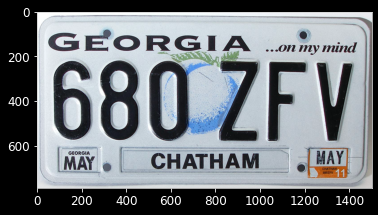

In [7]:
plt.imshow(image);

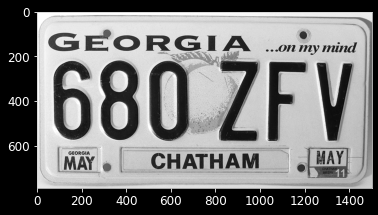

In [8]:
plt.imshow(gray, cmap="gray");

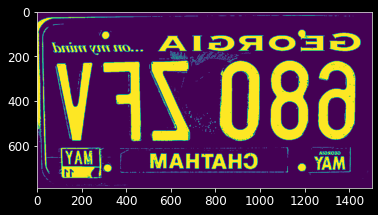

In [9]:
imshow(thresh)

**(?)** Why the image `thresh` is flipped horizontally?

In [10]:
image.shape, gray.shape, thresh.shape

((789, 1500, 3), (789, 1500), (789, 1500))

**(R)** I saw why: The image has no channels, i.e. it is a gray-scale image. The self-defined `imshow()` tries to reorder BGR to RGB, and in such a case reorders the second dimension, i.e. the columns, from right to left.

Let's redefine our `imshow()`

In [11]:
thresh.ndim

2

In [12]:
def imshow(array, bgr=True, cmap=None):
    if array.ndim == 2:
        plt.imshow(array, cmap="gray")
    else:
        if bgr:
            plt.imshow(array[...,::-1], cmap=cmap)
        else:
            plt.imshow(array, cmap=cmap)

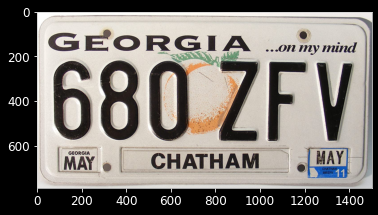

In [13]:
imshow(image)

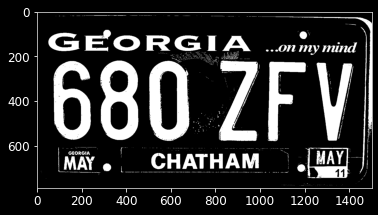

In [14]:
imshow(thresh)

As we have already been reminded in [Adrian's blog post](https://www.pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/): Even though the characters on the license plate of the original RGB image is black (and the background white), `thresh` has the **_colors reversed_**.

`thresh` is said to be a binary image. Let's verify that.

In [15]:
thresh.dtype

dtype('uint8')

In [16]:
np.unique(thresh)

array([  0, 255], dtype=uint8)

## Usage of `cv2.connectedComponentsWithStats`

In [17]:
connectivity = 4
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    thresh,
    connectivity,
    cv2.CV_32S,
)

In [18]:
cv2.CV_32S  # is a data type

4

To have a quick understanding of what `cv2.connectedComponentsWithStats()` does and what kind of ndarray `labels` is, there are great people who have already spent time and effort filming easy-to-understand YouTube videos, e.g. <https://www.youtube.com/watch?v=ticZclUYy88>

In [19]:
n_labels

1149

In [20]:
np.unique(labels).shape

(1149,)

In [21]:
labels.shape, thresh.shape

((789, 1500), (789, 1500))

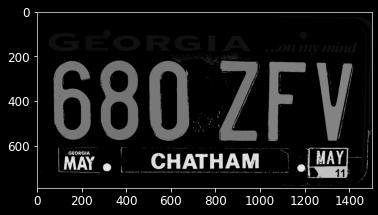

In [22]:
imshow(labels)

In [23]:
np.unique(labels)

array([   0,    1,    2, ..., 1146, 1147, 1148], dtype=int32)

In [24]:
stats

array([[     0,      0,   1500,    789, 907612],
       [   218,     19,    182,      2,    284],
       [    98,     21,      6,      2,      7],
       ...,
       [  1248,    779,      1,      1,      1],
       [  1255,    779,      1,      1,      1],
       [  1266,    779,      1,      1,      1]], dtype=int32)

In [25]:
centroids

array([[ 755.44178129,  393.54858133],
       [ 311.85915493,   19.49647887],
       [ 100.42857143,   21.85714286],
       ...,
       [1248.        ,  779.        ],
       [1255.        ,  779.        ],
       [1266.        ,  779.        ]])

In [26]:
centroids.dtype

dtype('float64')

How Adrian explains:

- `stats`: Statistics on each connected component, including the bounding box coordinates and area (in pixels)
- `centroids` are, obviously, the centroids of the connected components

The following cell can run on Fedora, but there are simply too many connected components if we do not discard those uninteresting ones. Maybe `AREA` is a good criteria for discarding them.